<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/debugging_airbnb_churn_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report


In [5]:
dataset_url = 'https://raw.githubusercontent.com/martin-fabbri/colab-notebooks/master/data/airbnb_churn.csv'
df = pd.read_csv(dataset_url, index_col=0)
labels = df.churn
features = df.drop('churn', axis=1)
features.head()

,host_is_superhost,price,room_type,accommodates,review_scores_cleanliness,review_scores_location,host_identity_verified,host_response_time,host_response_rate,host_has_profile_pic,availability_365,calculated_host_listings_count,calendar_updated,minimum_nights,number_of_reviews,reviews_per_month,days_since_last_review
19444,f,200.0,Entire home/apt,3,10.0,10.0,f,a few days or more,0.0,f,243.0,1.0,4 months ago,7,4,0.0,850.0
1520,f,450.0,Entire home/apt,4,10.0,10.0,f,a few days or more,0.0,f,208.0,1.0,2 weeks ago,3,7,0.0,505.0
1517,f,28.0,Shared room,1,0.0,0.0,f,a few days or more,0.0,f,364.0,1.0,6 weeks ago,1,0,0.0,3650.0
21691,f,48.0,Private room,2,8.0,6.0,f,a few days or more,0.0,f,143.0,1.0,4 months ago,1,1,0.0,612.0
21706,f,160.0,Private room,2,0.0,0.0,f,a few days or more,0.0,f,365.0,1.0,2 months ago,1,0,0.0,3650.0


In [0]:
drop_columns = ['host_response_time', 
                'calendar_updated',
                'days_since_last_review']

In [7]:
features.drop(drop_columns, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77201 entries, 19444 to 0
Data columns (total 14 columns):
host_is_superhost                 77201 non-null object
price                             77201 non-null float64
room_type                         77201 non-null object
accommodates                      77201 non-null int64
review_scores_cleanliness         77201 non-null float64
review_scores_location            77201 non-null float64
host_identity_verified            77201 non-null object
host_response_rate                77201 non-null float64
host_has_profile_pic              77201 non-null object
availability_365                  77201 non-null float64
calculated_host_listings_count    77201 non-null float64
minimum_nights                    77201 non-null int64
number_of_reviews                 77201 non-null int64
reviews_per_month                 77201 non-null float64
dtypes: float64(7), int64(3), object(4)
memory usage: 8.8+ MB


In [8]:
pd.get_dummies(features.drop(drop_columns, axis=1))

,price,accommodates,review_scores_cleanliness,review_scores_location,host_response_rate,availability_365,calculated_host_listings_count,minimum_nights,number_of_reviews,reviews_per_month,host_is_superhost_f,host_is_superhost_t,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_identity_verified_f,host_identity_verified_t,host_has_profile_pic_f,host_has_profile_pic_t
19444,200.0,3,10.0,10.0,0.0,243.0,1.0,7,4,0.00,1,0,1,0,0,1,0,1,0
1520,450.0,4,10.0,10.0,0.0,208.0,1.0,3,7,0.00,1,0,1,0,0,1,0,1,0
1517,28.0,1,0.0,0.0,0.0,364.0,1.0,1,0,0.00,1,0,0,0,1,1,0,1,0
21691,48.0,2,8.0,6.0,0.0,143.0,1.0,1,1,0.00,1,0,0,1,0,1,0,1,0
21706,160.0,2,0.0,0.0,0.0,365.0,1.0,1,0,0.00,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21723,59.0,1,7.0,10.0,100.0,202.0,1.0,2,41,1.50,1,0,0,1,0,0,1,0,1
21724,90.0,1,9.0,9.0,79.0,251.0,1.0,3,17,0.86,1,0,0,1,0,0,1,0,1
21725,200.0,3,10.0,10.0,0.0,206.0,1.0,2,9,0.78,0,1,1,0,0,0,1,0,1
21712,235.0,2,10.0,9.0,90.0,104.0,1.0,3,4,2.45,1,0,1,0,0,1,0,0,1


In [9]:
feature_matrix = pd.get_dummies(features.drop(drop_columns, axis=1)).as_matrix()
feature_matrix

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[200.,   3.,  10., ...,   0.,   1.,   0.],
       [450.,   4.,  10., ...,   0.,   1.,   0.],
       [ 28.,   1.,   0., ...,   0.,   1.,   0.],
       ...,
       [200.,   3.,  10., ...,   1.,   0.,   1.],
       [235.,   2.,  10., ...,   0.,   0.,   1.],
       [ 49.,   5.,  10., ...,   1.,   0.,   1.]])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels, test_size=0.3)

In [15]:

print(len(X_train))
print(len(X_test))

54040
23161


In [18]:
# create model (estimator) object
model = LogisticRegression(penalty='l2')
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
# make predictions
predictions = model.predict(X_test)
predictions

array([ True,  True,  True, ...,  True, False, False])

In [24]:
model.predict_proba(X_test)

array([[0.47281602, 0.52718398],
       [0.21131074, 0.78868926],
       [0.40666918, 0.59333082],
       ...,
       [0.47828474, 0.52171526],
       [0.57088263, 0.42911737],
       [0.72261918, 0.27738082]])

In [21]:
# evaluate model
accuracy = (predictions == y_test).sum() / len(y_test)
accuracy

0.690686930616122

In [22]:
model.score(X_test, y_test)

0.690686930616122

In [23]:
df.churn.value_counts()

True     44626
False    32575
Name: churn, dtype: int64

In [0]:
down_sample = df[df.churn == False].sample(32575)
sub_sample = pd.concat([down_sample, df[df.churn == True].sample(32575)])

In [26]:
sub_sample.churn.value_counts()

True     32575
False    32575
Name: churn, dtype: int64

In [27]:
labels = sub_sample.churn
drop_columns = ['host_response_time', 
                'calendar_updated',
                'days_since_last_review', 'churn']
features = sub_sample.drop(drop_columns, axis=1)
feature_matrix = pd.get_dummies(features).as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [0]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels, test_size=0.3)

In [29]:
# create model (estimator) object
clf = LogisticRegression(penalty='l1', solver='liblinear')

# fit model to training data
clf.fit(X_train, y_train)

# make predictions
predictions = clf.predict(X_test)

# evaluate model
accuracy = (predictions == y_test).sum() / len(y_test)
print(accuracy)

0.7244308007162957


In [30]:
print(f"Training took {clf.n_iter_[0]} iterations, since this is less than {clf.max_iter} it has converged")

Training took 29 iterations, since this is less than 100 it has converged


In [0]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(clf, X, y, param_name, param_range):
    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range,
        scoring="accuracy", n_jobs=-11)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

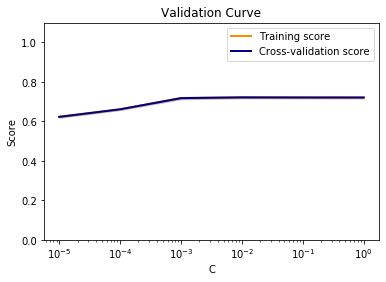

In [32]:

plot_validation_curve(clf, feature_matrix, labels, "C", param_range = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0])

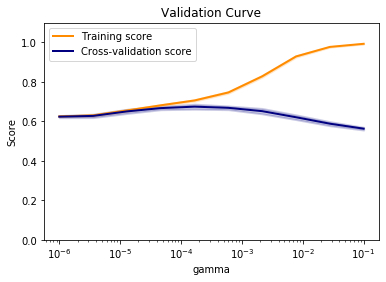

In [33]:
from sklearn.svm import SVC

plot_validation_curve(SVC(), X_train[:5000, :], y_train[:5000], "gamma", param_range = np.logspace(-6, -1, 10))

k-fold Cross Validation

In [0]:
scores = cross_val_score(clf, X_train, y_train, cv=10)

In [35]:
scores.mean()

0.719175653038538

In [36]:
scores.var()

1.372174843117981e-05

In [37]:

np.array([0.2, .2, .9, .8, .9, .5, .8, .7, .7, .7]).mean()

0.64

In [38]:
np.array([0.2, .2, .9, .8, .9, .5, .8, .7, .7, .7]).var()

0.06040000000000001

In [39]:
clf.score(X_test, y_test)

0.7244308007162957

In [40]:

model = KNeighborsClassifier()
clf = model.fit(X_train, y_train)
clf.score(X_test, y_test)

0.6679969301611666

In [42]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
clf = model.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7614735226400614

In [43]:
clf.feature_importances_

array([0.13160612, 0.0457223 , 0.03141784, 0.02609345, 0.07785389,
       0.2031209 , 0.03785426, 0.05378179, 0.07228028, 0.09691785,
       0.00286294, 0.00228194, 0.00716813, 0.00689555, 0.0030641 ,
       0.01853298, 0.02194741, 0.0748312 , 0.08576707])

In [44]:
clf.feature_importances_

array([0.13160612, 0.0457223 , 0.03141784, 0.02609345, 0.07785389,
       0.2031209 , 0.03785426, 0.05378179, 0.07228028, 0.09691785,
       0.00286294, 0.00228194, 0.00716813, 0.00689555, 0.0030641 ,
       0.01853298, 0.02194741, 0.0748312 , 0.08576707])

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[7877 1860]
 [2802 7006]]


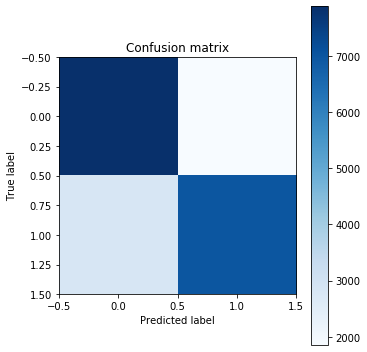

In [47]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cm)

In [48]:

y_pred

array([False,  True, False, ..., False, False,  True])

In [49]:
y_score

array([[0.6 , 0.4 ],
       [0.  , 1.  ],
       [0.86, 0.14],
       ...,
       [0.81, 0.19],
       [0.99, 0.01],
       [0.  , 1.  ]])

In [50]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.74      0.81      0.77      9737
        True       0.79      0.71      0.75      9808

    accuracy                           0.76     19545
   macro avg       0.76      0.76      0.76     19545
weighted avg       0.76      0.76      0.76     19545



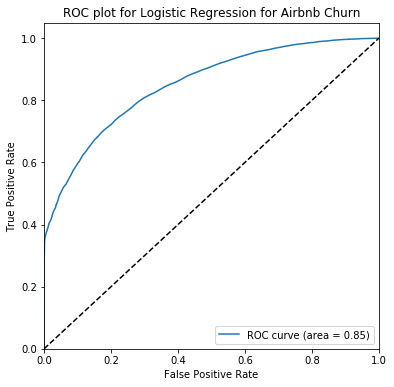

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC plot for Logistic Regression for Airbnb Churn')
plt.legend(loc="lower right")

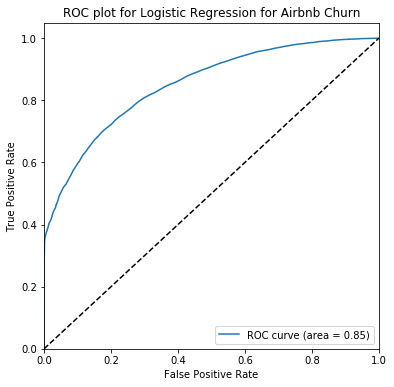

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC plot for Logistic Regression for Airbnb Churn')
plt.legend(loc="lower right")

In [0]:
scores = cross_validate(clf, X_train, y_train, return_train_score=True, cv=10)

In [54]:
scores

{'fit_time': array([5.46, 5.38, 5.39, 5.36, 5.4 , 5.32, 5.67, 5.88, 5.71, 5.93]),
 'score_time': array([0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.16, 0.16]),
 'test_score': array([0.76, 0.76, 0.76, 0.76, 0.77, 0.76, 0.75, 0.76, 0.77, 0.77]),
 'train_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=3,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(20, 10))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [0]:
clf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=2000)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

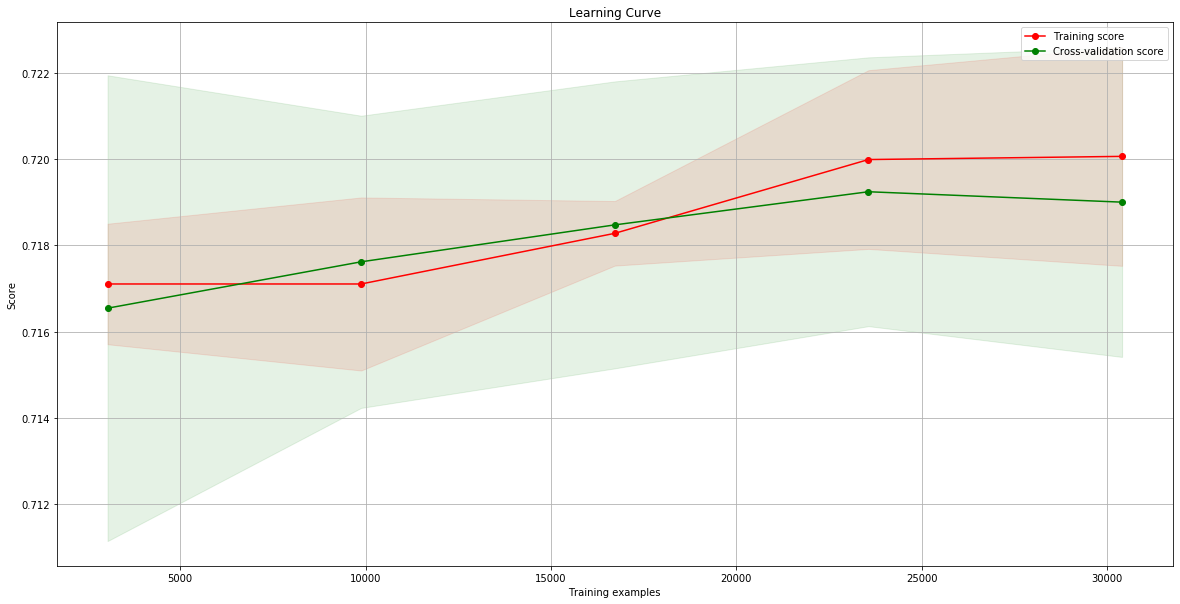

In [57]:

plot_learning_curve(clf, 'Learning Curve', X_train, y_train, train_sizes=np.linspace(.1, 1.0, 5), cv=3)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

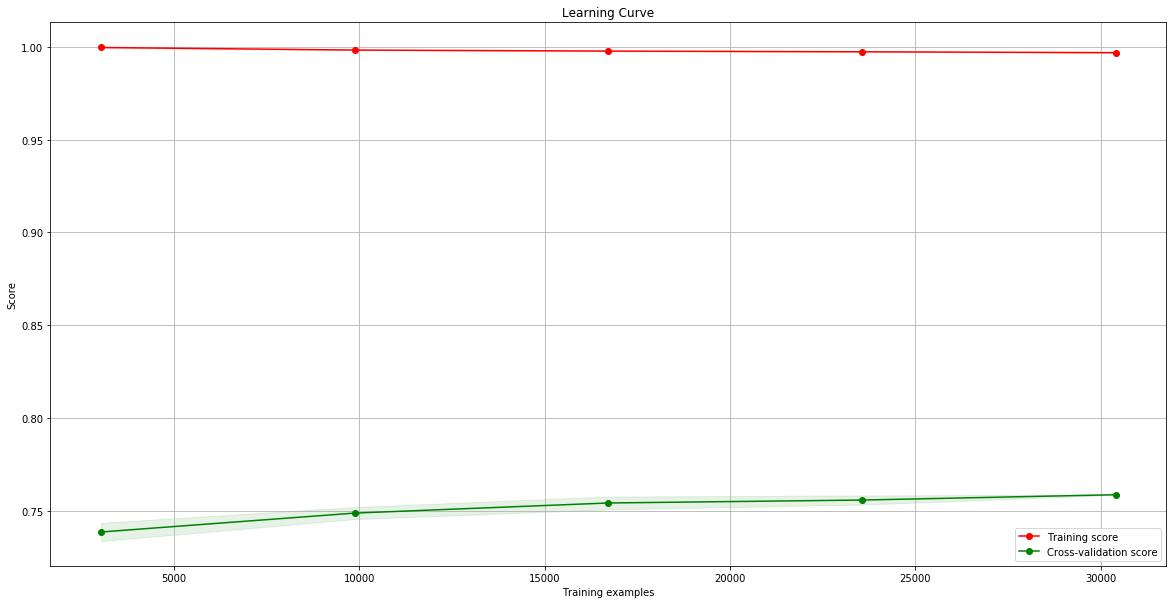

In [58]:

plot_learning_curve(RandomForestClassifier(), 'Learning Curve', X_train, y_train, train_sizes=np.linspace(.1, 1.0, 5))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

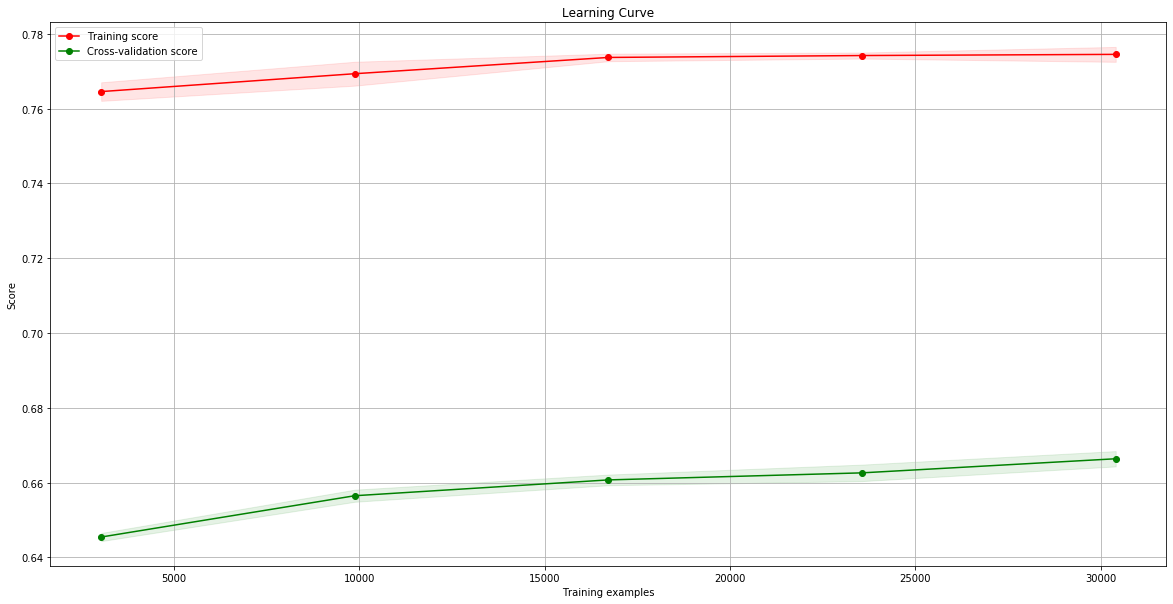

In [59]:

plot_learning_curve(KNeighborsClassifier(), 'Learning Curve', X_train, y_train, train_sizes=np.linspace(.1, 1.0, 5))